## Import modules

In [1]:
import os
import numpy as np
import math
import statistics
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Load output test probabilitites and true labels for each model

For every model there are 2 files generated in numpy binary format:

  **probabilities.npy** - numpy array of size **TEST POINT CLOUDS CLOUD x CLASSES COUNT x MODELS COUNT** with output classification probability for each of 10 individually trained models

  **true_labels.npy** - numpy array of size **TEST POINT CLOUDS CLOUD** with true labels data

In [2]:
# Base models
BASE_MODELS = ['pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn']
BASE_MODELS_ALIASES = ['PointNet', 'PointNet++', 'SO-Net', 'KCNet', 'DeepSets', 'DGCNN', 'PointCNN']
SONET_BAGGING_MODELS = ['so-net_sz_01', 'so-net_sz_02', 'so-net_sz_03', 'so-net_sz_04', 'so-net_sz_05', 'so-net_sz_06',
                        'so-net_sz_07', 'so-net_sz_08', 'so-net_sz_09', 'so-net_bagging']
SONET_CONST_MODELS = ['so-net_TTT', 'so-net_FFT', 'so-net_FTF', 'so-net_TFF', 'so-net_TTF', 'so-net_TFT', 'so-net_FTT']
SONET_CLASSIFIER_ENSEMBLE = ['so-net_' + str(i) for i in range(1, 11)]
ALL_MODELS = BASE_MODELS + SONET_BAGGING_MODELS + SONET_CONST_MODELS + SONET_CLASSIFIER_ENSEMBLE

CLASS_NAMES = ['airplane', 'bathtub', 'bed', 'bench', 'bookshelf', 'bottle', 'bowl',
               'car', 'chair', 'cone', 'cup', 'curtain', 'desk', 'door', 'dresser',
               'flower_pot', 'glass_box', 'guitar', 'keyboard', 'lamp', 'laptop',
               'mantel', 'monitor', 'night_stand', 'person', 'piano', 'plant', 'radio',
               'range_hood', 'sink', 'sofa', 'stairs', 'stool', 'table', 'tent', 'toilet',
               'tv_stand', 'vase', 'wardrobe', 'xbox']
CLASS_TEST_INSTANCES = [100, 50, 100, 20, 100, 100, 20, 100, 100, 20, 20, 20, 86, 20,
                        86, 20, 100, 100, 20, 20, 20, 100, 100, 86, 20, 100, 100, 20,
                        100, 20, 100, 20, 20, 100, 20, 100, 100, 100, 20, 20]
CLASSES_COUNT = 40
# MODELS_COUNT = 10
# ENSEMBLE_MODELS_NUMBER = 10

probabilities = {}
true_labels = {}
for model in ALL_MODELS:
    for dir_name in ['models_reordered', 'models_raw', 'models_bagging', 'models_const', 'models_classifier_ensemble']:
        if os.path.exists(os.path.join(dir_name, model)):
            break
    prob_filepath = os.path.join(os.path.join(dir_name, model), 'probabilities.npy')
    label_filepath = os.path.join(os.path.join(dir_name, model), 'true_labels.npy')
    probabilities[model] = np.load(prob_filepath)
    if dir_name != 'models_reordered':
        probabilities[model] = np.transpose(probabilities[model], axes=(2, 0, 1))

    # probabilities[model] =  softmax(probabilities[model])
    idx = np.argmax(probabilities[model], axis=-1)
    hardvote = np.squeeze(np.eye(40)[idx.reshape(-1)]).reshape(probabilities[model].shape)
    e_x = np.exp(probabilities[model])
    softvote = e_x /np.expand_dims(np.sum(e_x, axis=-1), axis=-1)
    probabilities[model] = {'activations': probabilities[model]/np.std(probabilities[model]),
                           'hardvote': hardvote, 'softvote': softvote}
    true_labels[model] = np.load(label_filepath)
    
    for class_idx in range(CLASSES_COUNT):
        error_info = ("Test cloud instances for model " + model + " and class "
                      + str(class_idx) + " differs! Should be " + str(CLASS_TEST_INSTANCES[class_idx])
                      + " but got " + str(np.sum(true_labels[model] == class_idx)))
        assert np.sum(true_labels[model] == class_idx) == CLASS_TEST_INSTANCES[class_idx] or \
          (model=='deepsets' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19) or \
          (model=='deepsets_ep100' and class_idx==12 and np.sum(true_labels[model] == class_idx) == 85) or \
          (model=='deepsets_ep100' and class_idx==39 and np.sum(true_labels[model] == class_idx) == 19), \
          error_info
                
#     assert (probabilities[model].shape[0] == ENSEMBLE_MODELS_NUMBER)
    assert (probabilities[model]['activations'].shape[1] == 2468 or \
            (model=='deepsets' and probabilities[model]['activations'].shape[1] == 2466) or \
           (model=='deepsets_ep100' and probabilities[model]['activations'].shape[1] == 2466))
    assert (probabilities[model]['activations'].shape[2] == CLASSES_COUNT)

## Caclulate statistics

In [3]:
####################################################################################
# Get random subsets
####################################################################################

def get_k_combinations_of_n_elems(n, k, rep):
    """
    Get rep different k-combinations of set of n numbers. If requested reps is greater
    than possible combinations number just return all possible combinations. In our case:
    n - maximum number of ensembled models
    k - actual number of ensembled models
    rep - how many different k subsets of n we want to generate.    
    """
    c_n_k = math.factorial(n) / math.factorial(k) / math.factorial(n-k)
    combinations_number = min(c_n_k, rep)
    
    subsets = []   
    while len(subsets) != combinations_number:
        candidate = np.sort(np.random.choice(n, k, replace=False))
        if not np.array([(el == candidate).all() for el in subsets]).any():
            subsets.append(candidate)
    return np.array(subsets)
        
####################################################################################
# Calc accuracy statistics
####################################################################################

def get_stats_for_num_ens_param(params_list):
    stats = {}
    stats['mean'] = statistics.mean(params_list)
    stats['stddev'] = statistics.stdev(params_list) if len(params_list) > 1 else 0.0
    stats['median'] = statistics.median(params_list)
    stats['min'] = min(params_list)
    stats['max'] = max(params_list)
    return stats

def get_accuracy_stats(models_list, voting_method='activations'):
    accuracy_stats = {}
    for model in models_list:
        subsets = {}
        
        num_ensemble_models = probabilities[model][voting_method].shape[0]
        for num_ens in range(1, num_ensemble_models+1):
            subset = get_k_combinations_of_n_elems(len(probabilities[model][voting_method]),
                                                   num_ens, 100)
            subsets[num_ens] = subset
            
        accuracy_stats[model] = {}

        for num_ens in subsets:
            num_ens_accs = []
            for subset in subsets[num_ens]:
                preds = np.argmax(np.mean(probabilities[model][voting_method][subset], axis=0), axis=-1)
                true = true_labels[model]

                acc = float(np.sum(preds == true))/len(true)
                class_accs = []
                for class_idx in range(CLASSES_COUNT):
                    class_acc = float(np.sum((preds == true) * (true == class_idx)))/float(np.sum(true == class_idx))
                    class_accs.append(class_acc)
                mean_class_acc = statistics.mean(class_accs)
                num_ens_accs.append({'acc': acc, 'mean_class_acc': mean_class_acc, 'class_accs': class_accs})

            num_ens_summary = {}
            num_ens_summary['acc'] = get_stats_for_num_ens_param([x['acc'] for x in num_ens_accs])
            num_ens_summary['mean_class_acc'] = get_stats_for_num_ens_param([x['mean_class_acc'] for x in num_ens_accs])
            num_ens_summary['class_accs'] = []
            for class_idx in range(CLASSES_COUNT):
                num_ens_summary['class_accs'].append(get_stats_for_num_ens_param([x['class_accs'][class_idx] 
                                                                                  for x in num_ens_accs]))
            accuracy_stats[model][num_ens] = num_ens_summary
    return accuracy_stats

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

def plot_acc_in_num_models(ax, acc_stats, acc_type='acc', styles={}, h_factor=0.1, times=None, without_errorbar=False):
    for model in acc_stats:
        x = acc_stats[model].keys()
        y = [acc_stats[model][i][acc_type]['mean'] for i in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            e = [acc_stats[model][i][acc_type]['stddev'] for i in x]
        if times is not None:
            x = [v * times[model] for v in x]
        if 'stddev' in acc_stats[model][1][acc_type] and not without_errorbar:
            ax.errorbar(x, y, e, label=styles[model]['label'], capsize=6, 
                               color=styles[model]['color'],
                              linestyle=styles[model]['linestyle'])
        else:
            ax.plot(x, y, label=styles[model]['label'], 
                               color=styles[model]['color'],
                              linestyle=styles[model]['linestyle'])
       
    if times is None:
        ax.set_xlabel('Number of ensembled models')
    else:
        ax.set_xlabel('Inference time for batch of 4 point clouds [ms]')
        
    if acc_type == 'acc':
        ax.set_ylabel('Instance classification accuracy')
    elif acc_type == 'mean_class_acc':
        ax.set_ylabel('Mean class accuracy')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * h_factor,
                     box.width, box.height * (1.0 - h_factor)])

    # Show tick labels
    for tk in ax.get_yticklabels():
        tk.set_visible(True)
        
    return ax.get_legend_handles_labels()

## Choose voting method

In [4]:
acc_stats_base_models_voting = {method: get_accuracy_stats(BASE_MODELS, method) for method in 
                                ['activations', 'hardvote', 'softvote']}

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


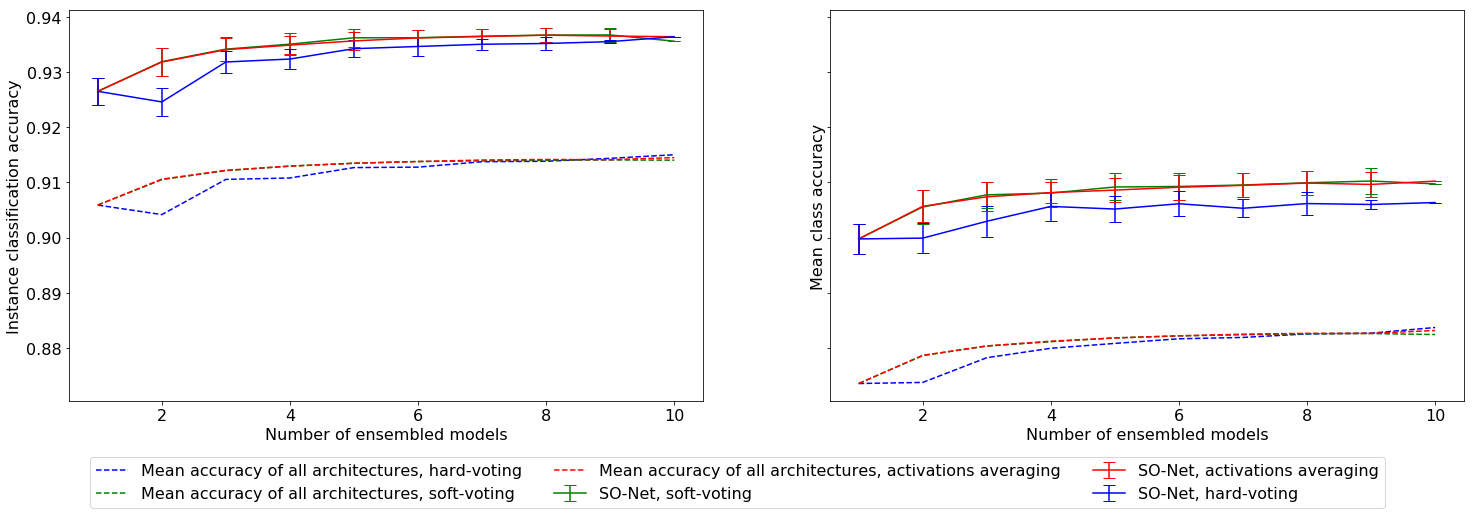

In [5]:
compare_sonet = {method: acc_stats_base_models_voting[method]['so-net'] for method in acc_stats_base_models_voting}
compare_mean_arch = {}
for method in acc_stats_base_models_voting:
    mean_arch_acc = {}
    mean_arch_mca = {}
    for arch in acc_stats_base_models_voting[method]:
        arch_voting = acc_stats_base_models_voting[method][arch]
        for num_models in arch_voting:
            arch_num = arch_voting[num_models]
            arch_num_acc = arch_num['acc']
            arch_num_mca = arch_num['mean_class_acc']
            if num_models not in mean_arch_acc:
                mean_arch_acc[num_models] = []
            if num_models not in mean_arch_mca:
                mean_arch_mca[num_models] = []
            mean_arch_acc[num_models].append(arch_num_acc['mean'])
            mean_arch_mca[num_models].append(arch_num_mca['mean'])
    mean_arch_acc = {x: np.mean(mean_arch_acc[x]) for x in mean_arch_acc}
    mean_arch_mca = {x: np.mean(mean_arch_mca[x]) for x in mean_arch_mca}
    compare_mean_arch[method] = {x: {'acc': {'mean': mean_arch_acc[x]}, 
                                     'mean_class_acc': {'mean': mean_arch_mca[x]}} 
                                 for x in mean_arch_acc}
compare_voting = {}
for item in compare_sonet:
    compare_voting['so-net ' + item] = compare_sonet[item]
for item in compare_mean_arch:
    compare_voting['mean arch ' + item] = compare_mean_arch[item]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
styles = {'so-net activations': {'color': 'r', 'linestyle': '-', 'label': 'SO-Net, activations averaging'},
         'so-net softvote': {'color': 'g', 'linestyle': '-', 'label': 'SO-Net, soft-voting'},
         'so-net hardvote': {'color': 'b', 'linestyle': '-', 'label': 'SO-Net, hard-voting'},
         'mean arch activations': {'color': 'r', 'linestyle': '--',
                                   'label': 'Mean accuracy of all architectures, activations averaging'},
         'mean arch softvote': {'color': 'g', 'linestyle': '--',
                                'label': 'Mean accuracy of all architectures, soft-voting'},
         'mean arch hardvote': {'color': 'b', 'linestyle': '--',
                               'label': 'Mean accuracy of all architectures, hard-voting'}}
handles, labels = plot_acc_in_num_models(ax1, compare_voting, 'acc', styles)
plot_acc_in_num_models(ax2, compare_voting, 'mean_class_acc', styles)
f.legend(handles=handles, loc='lower center', ncol=3)
f.savefig('images/voting_methods.png', bbox_inches='tight')

## Plot accuracies in function of ensembled models

In [6]:
acc_stats_base_models = get_accuracy_stats(BASE_MODELS, 'activations')

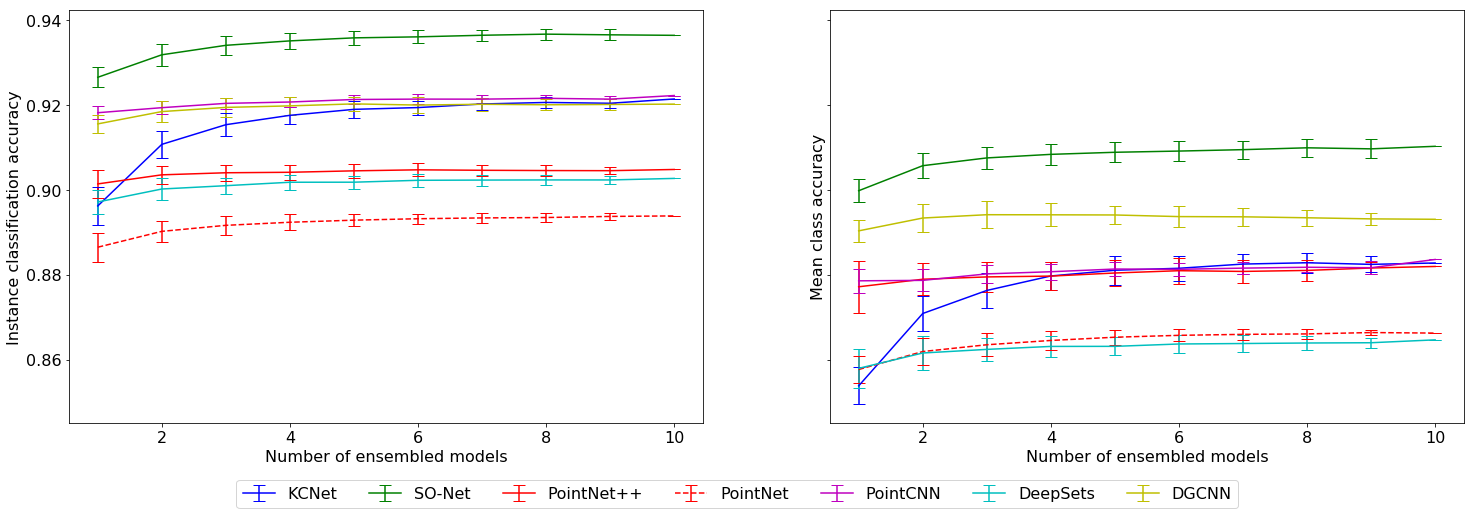

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 8))
#'pointnet', 'pointnet++', 'so-net', 'kcnet', 'deepsets', 'dgcnn', 'pointcnn'
styles = {'pointnet': {'color': 'r', 'linestyle': '--', 'label': 'PointNet'},
         'pointnet++': {'color': 'r', 'linestyle': '-', 'label': 'PointNet++'},
         'so-net': {'color': 'g', 'linestyle': '-', 'label': 'SO-Net'},
         'kcnet': {'color': 'b', 'linestyle': '-', 'label': 'KCNet'},
         'deepsets': {'color': 'c', 'linestyle': '-', 'label': 'DeepSets'},
         'dgcnn': {'color': 'y', 'linestyle': '-', 'label': 'DGCNN'},
         'pointcnn': {'color': 'm', 'linestyle': '-', 'label': 'PointCNN'},}
h = 0.05
handles, labels = plot_acc_in_num_models(ax1, acc_stats_base_models, 'acc', styles, h)
plot_acc_in_num_models(ax2, acc_stats_base_models, 'mean_class_acc', styles, h)
f.legend(handles=handles, loc='lower center', ncol=7)
f.savefig('images/models_accuracy.png', bbox_inches='tight')

## Compare results with and without ensemble

In [8]:
data = []
TOTAL_NUM_MODELS = 10
for model in BASE_MODELS:
    data.append([100 * acc_stats_base_models[model][1]['acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['acc']['mean'],
                 100 * acc_stats_base_models[model][1]['mean_class_acc']['mean'],
                 100 * acc_stats_base_models[model][TOTAL_NUM_MODELS]['mean_class_acc']['mean']])
pd.options.display.float_format = '{:,.2f}%'.format
df = pd.DataFrame(data, columns=['Plain acc mean', 'Ensemble acc mean', 
                                 'Plain class acc mean', 'Ensemble class acc mean'], index=BASE_MODELS)
df['Increase acc'] = df['Ensemble acc mean'] - df['Plain acc mean']
df['Increase class acc'] = df['Ensemble class acc mean'] - df['Plain class acc mean']
df

,Plain acc mean,Ensemble acc mean,Plain class acc mean,Ensemble class acc mean,Increase acc,Increase class acc
pointnet,88.65%,89.38%,85.77%,86.62%,0.74%,0.86%
pointnet++,90.14%,90.48%,87.71%,88.19%,0.34%,0.48%
so-net,92.65%,93.64%,89.98%,91.02%,0.99%,1.05%
kcnet,89.62%,92.14%,85.38%,88.28%,2.52%,2.89%
deepsets,89.71%,90.27%,85.79%,86.46%,0.56%,0.67%
dgcnn,91.55%,92.02%,89.03%,89.30%,0.47%,0.27%
pointcnn,91.82%,92.22%,87.85%,88.36%,0.41%,0.50%


# Classification accuracy gain or loose per class

In [9]:
min_values = []
for idx in range(CLASSES_COUNT):
    class_plain_mean = [100 * acc_stats_base_models[x][1]['class_accs'][idx]['mean'] for x in BASE_MODELS]
    class_ensemble_mean = [100 * acc_stats_base_models[x][10]['class_accs'][idx]['mean'] for x in BASE_MODELS]
    min_values.append((CLASS_NAMES[idx], idx, min(class_ensemble_mean + class_plain_mean)))
min_values = sorted(min_values, key=lambda x: x[-1])
low_acc_classes = sorted(min_values[:15], key=lambda x: x[1])
high_acc_classes = sorted(min_values[15:], key=lambda x: x[1])

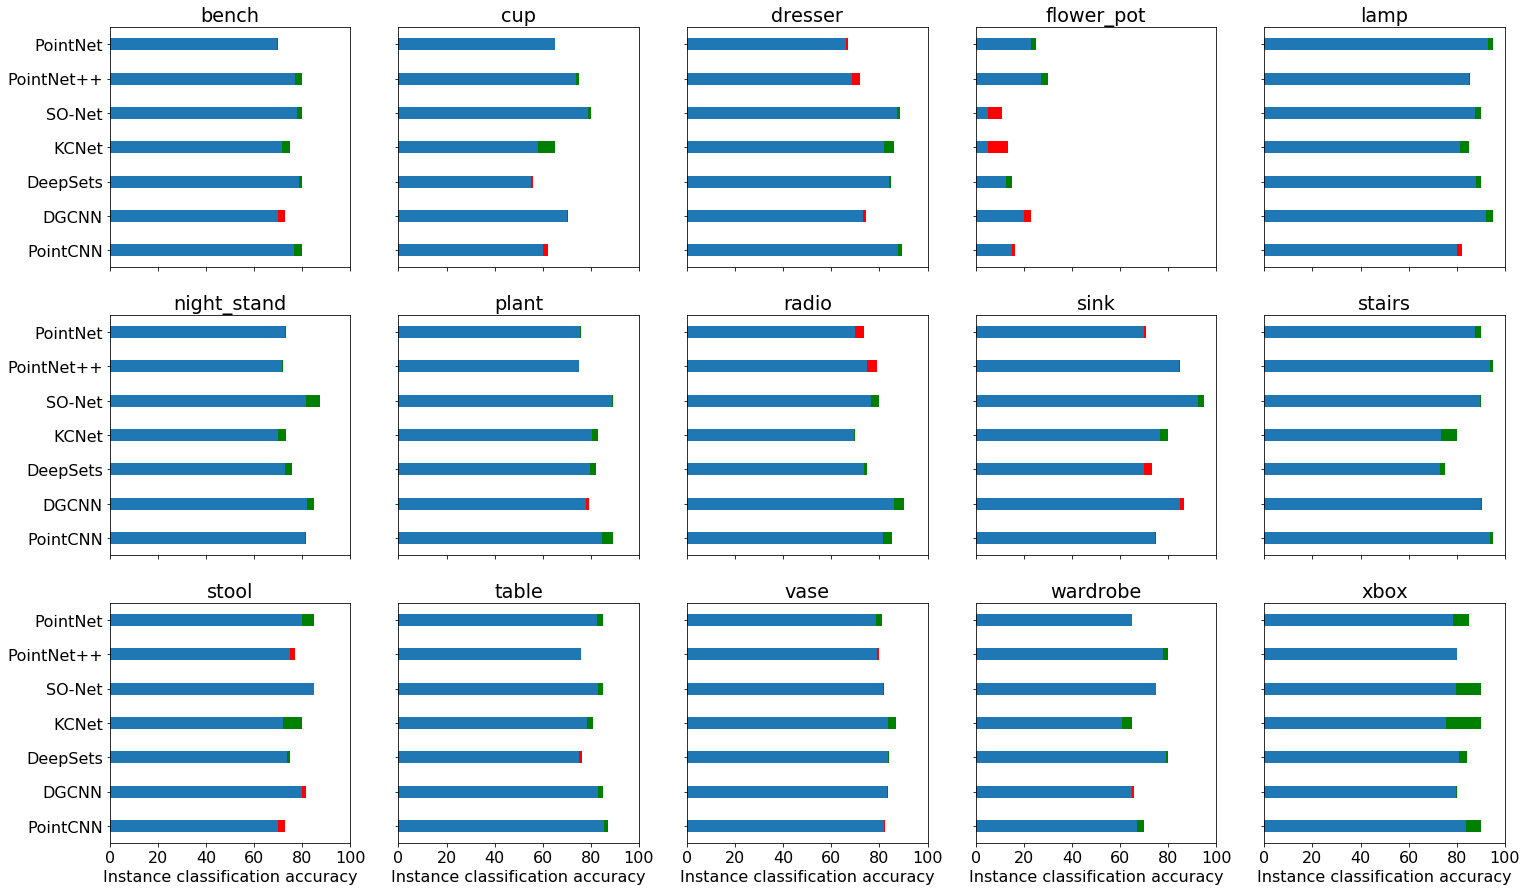

In [10]:
def draw_class_accs_horizontal(acc_classes_list, y_lim):
    ind = np.arange(len(BASE_MODELS))    # the x locations for the groups
    width = 0.35       # the width of the bars: can also be len(x) sequence

    num_cols = 5
    num_rows = int(len(acc_classes_list) / num_cols)
    f, axes = plt.subplots(num_rows, num_cols, sharey=True, sharex=True, figsize=(25, 5 * num_rows))
    plt.setp(axes, yticks=ind, yticklabels=np.flip(BASE_MODELS_ALIASES), xticks=range(y_lim[0],y_lim[1] + 1, int((y_lim[1]-y_lim[0])/5)))
    

    for c in range(num_cols):
        for r in range(num_rows):
            tmp_idx = c + num_cols * r
            idx = acc_classes_list[tmp_idx][1]
            class_plain_mean = [100 * acc_stats_base_models[x][1]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            class_ensemble_mean = [100 * acc_stats_base_models[x][10]['class_accs'][idx]['mean'] for x in BASE_MODELS]
            diff = [class_ensemble_mean[x] - class_plain_mean[x] for x in range(len(class_plain_mean))]
            diff_up = [x if x > 0 else 0 for x in diff]
            diff_down = [x if x < 0 else 0 for x in diff]
            axes[r][c].barh(ind, np.flip(class_plain_mean), width, label='Plain')
            axes[r][c].barh(ind, np.flip(diff_up), width, left=np.flip(class_plain_mean), label='Diff', color='g')
            axes[r][c].barh(ind, np.flip(diff_down), width, left=np.flip(class_plain_mean), label='Diff', color='r')
            axes[r][c].set_title(CLASS_NAMES[idx])
            axes[r][c].set_xlim(y_lim)
            if r == num_rows - 1:
                axes[r][c].set_xlabel('Instance classification accuracy')
    return f

f = draw_class_accs_horizontal(low_acc_classes, [0, 100])
f.savefig('images/class_accuracy_1.png', bbox_inches='tight')

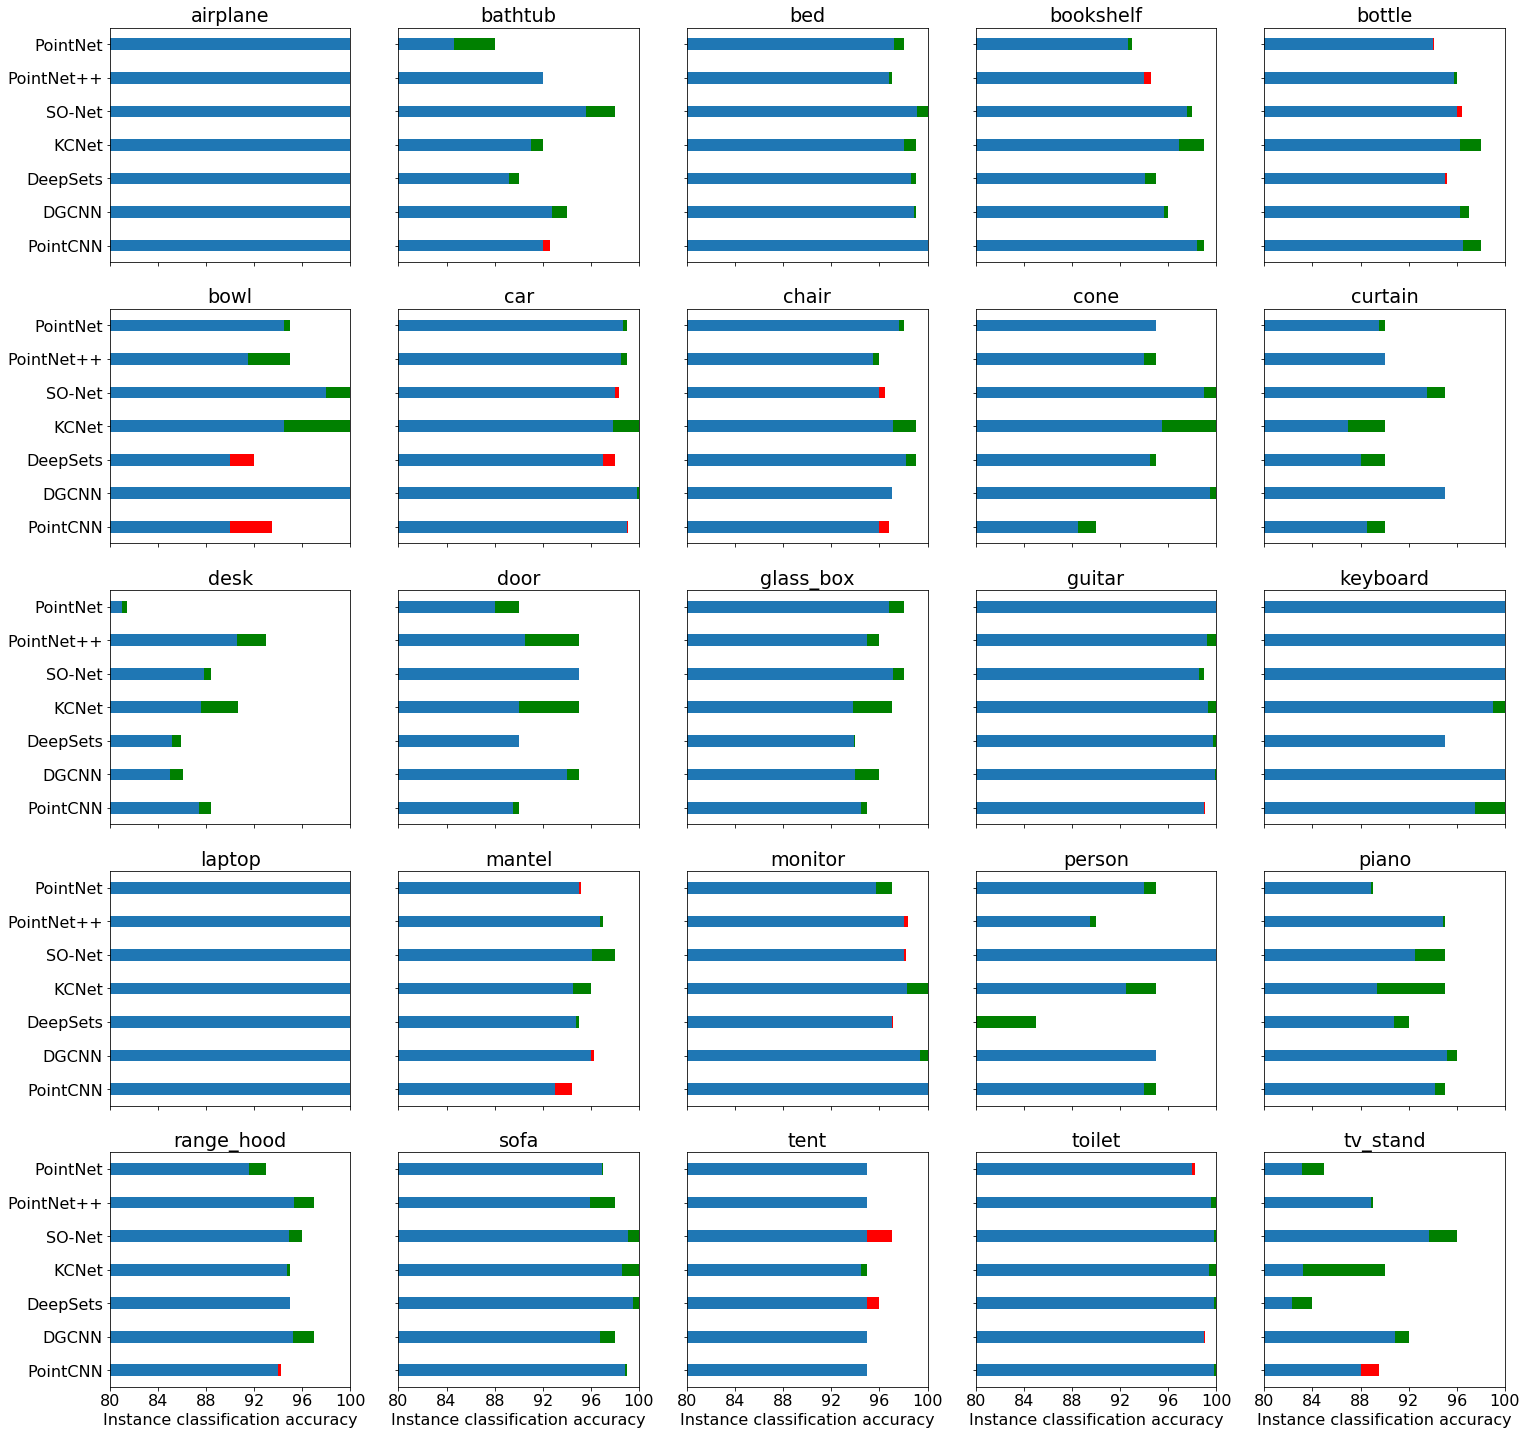

In [11]:
f = draw_class_accs_horizontal(high_acc_classes, [80, 100])
f.savefig('images/class_accuracy_2.png', bbox_inches='tight')

## Who's the best?
In how many classes is each model the best one?

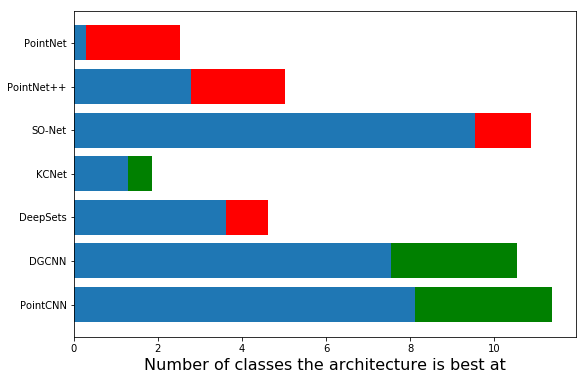

In [13]:
ind = np.arange(len(BASE_MODELS))
models_wins_plain = {x: 0 for x in BASE_MODELS}
models_wins_ensemble = {x: 0 for x in BASE_MODELS}
for idx in range(CLASSES_COUNT):
    class_plain_mean = sorted([(acc_stats_base_models[x][1]['class_accs'][idx]['mean'], x) for x in BASE_MODELS],
                              key=lambda x: x[0])
    class_ensemble_mean = sorted([(acc_stats_base_models[x][10]['class_accs'][idx]['mean'], x) for x in BASE_MODELS],
                                 key=lambda x: x[0])
    num_winners = 0.
    for j in range(len(class_plain_mean)):
        if class_plain_mean[-1][0] == class_plain_mean[j][0]:
            num_winners += 1.
    for j in range(len(class_plain_mean)):
        if class_plain_mean[-1][0] == class_plain_mean[j][0]:
            models_wins_plain[class_plain_mean[j][1]] += 1./num_winners
            models_wins_ensemble[class_ensemble_mean[j][1]] += 1./num_winners

    base = [models_wins_plain[x] for x in BASE_MODELS]

plt.figure(figsize=(9, 6))
diff = [models_wins_ensemble[x] - models_wins_plain[x] for x in BASE_MODELS]
diff_up = [x if x>0 else 0 for x in diff]
diff_down = [x if x<0 else 0 for x in diff]
plt.barh(ind, np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.barh(ind, np.flip(diff_up, axis=-1), color='g', left=np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.barh(ind, np.flip(diff_down, axis=-1), color='r', left=np.flip(base, axis=-1), tick_label=np.flip(BASE_MODELS_ALIASES, axis=-1))
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.xlabel('Number of classes the architecture is best at')
plt.savefig('images/whos_the_best_horizontal.png', bbox_inches='tight')

In [59]:
voting_method = 'activations'
for model in BASE_MODELS:
    
    # How many learned models
    learned_models_no = probabilities[model][voting_method].shape[0]
    assert learned_models_no == 10, 'There should be 10 learned models for each architecture'
    
    # Calc ensemble scores & votes
    ensemble_scores = np.mean(probabilities[model][voting_method], axis=0)
    ensemble_votes = np.argmax(ensemble_scores, axis=-1)
    
    # Get single scores & votes
    #model_instance_idx = np.random.choice(np.arange(learned_models_no))
    model_instance_idx = 0
    single_scores = probabilities[model][voting_method][model_instance_idx]
    single_votes = np.argmax(single_scores, axis=-1)
    
    # Print all cases where ensemble is better than score
    misclassifications = []
    for test_cloud_idx, _ in enumerate(true_labels[model]):
        old_hit = single_votes[test_cloud_idx] == true_labels[model][test_cloud_idx]
        new_hit = ensemble_votes[test_cloud_idx] == true_labels[model][test_cloud_idx]
        if not old_hit and new_hit:
            print ('model', model, 'old_hit:', single_votes[test_cloud_idx], 'new_hit:', ensemble_votes[test_cloud_idx], 'test_cloud_idx', test_cloud_idx)
            misclassifications.append((single_votes[test_cloud_idx], ensemble_votes[test_cloud_idx]))
    break

model pointnet old_hit: 16 new_hit: 1 test_cloud_idx 117
model pointnet old_hit: 30 new_hit: 1 test_cloud_idx 127
model pointnet old_hit: 33 new_hit: 2 test_cloud_idx 176
model pointnet old_hit: 13 new_hit: 4 test_cloud_idx 281
model pointnet old_hit: 36 new_hit: 7 test_cloud_idx 528
model pointnet old_hit: 34 new_hit: 9 test_cloud_idx 696
model pointnet old_hit: 37 new_hit: 10 test_cloud_idx 725
model pointnet old_hit: 30 new_hit: 12 test_cloud_idx 802
model pointnet old_hit: 22 new_hit: 13 test_cloud_idx 847
model pointnet old_hit: 38 new_hit: 14 test_cloud_idx 859
model pointnet old_hit: 23 new_hit: 14 test_cloud_idx 929
model pointnet old_hit: 26 new_hit: 15 test_cloud_idx 956
model pointnet old_hit: 37 new_hit: 19 test_cloud_idx 1189
model pointnet old_hit: 25 new_hit: 21 test_cloud_idx 1257
model pointnet old_hit: 28 new_hit: 22 test_cloud_idx 1356
model pointnet old_hit: 4 new_hit: 22 test_cloud_idx 1372
model pointnet old_hit: 36 new_hit: 23 test_cloud_idx 1454
model pointnet o

In [60]:
print ('for pointnet there are much confusion between:')
print ('should be 26 :', CLASS_NAMES[26], 'but he think it\'s 15', CLASS_NAMES[15])
print ('should be 33 :', CLASS_NAMES[33], 'but he think it\'s 12', CLASS_NAMES[12])

for pointnet there are much confusion between:
should be 26 : plant but he think it's 15 flower_pot
should be 33 : table but he think it's 12 desk


In [64]:
voting_method = 'activations'
for model in BASE_MODELS:
    
    # Get single scores & votes
    #model_instance_idx = np.random.choice(np.arange(learned_models_no))
    model_instance_idx = 0
    single_scores = probabilities[model][voting_method][model_instance_idx]
    single_votes = np.argmax(single_scores, axis=-1)
    
    # Print all cases where we make the same mistake, which ensemble prevented
    
    for misclassification in misclassifications:
        how_much = 0
        for test_cloud_idx, _ in enumerate(true_labels[model]):
            if single_votes[test_cloud_idx] == misclassification[0] and true_labels[model][test_cloud_idx] == misclassification[1]:
                #print ('model', model, 'old_hit:', single_votes[test_cloud_idx], 'true_label:', ensemble_votes[test_cloud_idx], 'test_cloud_idx', test_cloud_idx)
                how_much += 1
        print ('How much:', how_much, 'missclassification of type', misclassification)
    break

How much: 1 missclassification of type (16, 1)
How much: 1 missclassification of type (30, 1)
How much: 1 missclassification of type (33, 2)
How much: 2 missclassification of type (13, 4)
How much: 1 missclassification of type (36, 7)
How much: 1 missclassification of type (34, 9)
How much: 5 missclassification of type (37, 10)
How much: 3 missclassification of type (30, 12)
How much: 1 missclassification of type (22, 13)
How much: 8 missclassification of type (38, 14)
How much: 8 missclassification of type (23, 14)
How much: 11 missclassification of type (26, 15)
How much: 1 missclassification of type (37, 19)
How much: 1 missclassification of type (25, 21)
How much: 1 missclassification of type (28, 22)
How much: 1 missclassification of type (4, 22)
How much: 3 missclassification of type (36, 23)
How much: 2 missclassification of type (4, 23)
How much: 1 missclassification of type (2, 25)
How much: 1 missclassification of type (31, 26)
How much: 14 missclassification of type (15, 26)

In [65]:
voting_method = 'activations'
for model in ['kcnet']:
    
    # How many learned models
    learned_models_no = probabilities[model][voting_method].shape[0]
    assert learned_models_no == 10, 'There should be 10 learned models for each architecture'
    
    # Calc ensemble scores & votes
    ensemble_scores = np.mean(probabilities[model][voting_method], axis=0)
    ensemble_votes = np.argmax(ensemble_scores, axis=-1)
    
    # Get single scores & votes
    #model_instance_idx = np.random.choice(np.arange(learned_models_no))
    model_instance_idx = 0
    single_scores = probabilities[model][voting_method][model_instance_idx]
    single_votes = np.argmax(single_scores, axis=-1)
    
    # Print all cases where ensemble is better than score
    misclassifications = []
    for test_cloud_idx, _ in enumerate(true_labels[model]):
        old_hit = single_votes[test_cloud_idx] == true_labels[model][test_cloud_idx]
        new_hit = ensemble_votes[test_cloud_idx] == true_labels[model][test_cloud_idx]
        if not old_hit and new_hit:
            print ('model', model, 'old_hit:', single_votes[test_cloud_idx], 'new_hit:', ensemble_votes[test_cloud_idx], 'test_cloud_idx', test_cloud_idx)
            misclassifications.append((single_votes[test_cloud_idx], ensemble_votes[test_cloud_idx]))
    break

model kcnet old_hit: 33 new_hit: 2 test_cloud_idx 229
model kcnet old_hit: 29 new_hit: 3 test_cloud_idx 256
model kcnet old_hit: 23 new_hit: 4 test_cloud_idx 286
model kcnet old_hit: 25 new_hit: 4 test_cloud_idx 304
model kcnet old_hit: 21 new_hit: 4 test_cloud_idx 328
model kcnet old_hit: 37 new_hit: 4 test_cloud_idx 330
model kcnet old_hit: 37 new_hit: 5 test_cloud_idx 416
model kcnet old_hit: 37 new_hit: 5 test_cloud_idx 450
model kcnet old_hit: 37 new_hit: 5 test_cloud_idx 469
model kcnet old_hit: 27 new_hit: 7 test_cloud_idx 528
model kcnet old_hit: 34 new_hit: 7 test_cloud_idx 559
model kcnet old_hit: 34 new_hit: 9 test_cloud_idx 698
model kcnet old_hit: 15 new_hit: 10 test_cloud_idx 712
model kcnet old_hit: 15 new_hit: 10 test_cloud_idx 722
model kcnet old_hit: 22 new_hit: 11 test_cloud_idx 732
model kcnet old_hit: 13 new_hit: 11 test_cloud_idx 744
model kcnet old_hit: 29 new_hit: 12 test_cloud_idx 754
model kcnet old_hit: 33 new_hit: 12 test_cloud_idx 783
model kcnet old_hit: 3

In [68]:
print ('for kcnet there are much confusion between:')
print ('should be 14 :', CLASS_NAMES[14], 'but he think it\'s 23', CLASS_NAMES[23])
print ('should be 26 :', CLASS_NAMES[26], 'but he think it\'s 15', CLASS_NAMES[15])

for kcnet there are much confusion between:
should be 14 : dresser but he think it's 23 night_stand
should be 26 : plant but he think it's 15 flower_pot


In [66]:
voting_method = 'activations'
for model in ['kcnet']:
    
    # Get single scores & votes
    #model_instance_idx = np.random.choice(np.arange(learned_models_no))
    model_instance_idx = 0
    single_scores = probabilities[model][voting_method][model_instance_idx]
    single_votes = np.argmax(single_scores, axis=-1)
    
    # Print all cases where we make the same mistake, which ensemble prevented
    
    for misclassification in misclassifications:
        how_much = 0
        for test_cloud_idx, _ in enumerate(true_labels[model]):
            if single_votes[test_cloud_idx] == misclassification[0] and true_labels[model][test_cloud_idx] == misclassification[1]:
                #print ('model', model, 'old_hit:', single_votes[test_cloud_idx], 'true_label:', ensemble_votes[test_cloud_idx], 'test_cloud_idx', test_cloud_idx)
                how_much += 1
        print ('How much:', how_much, 'missclassification of type', misclassification)
    break

How much: 1 missclassification of type (33, 2)
How much: 1 missclassification of type (29, 3)
How much: 1 missclassification of type (23, 4)
How much: 1 missclassification of type (25, 4)
How much: 1 missclassification of type (21, 4)
How much: 1 missclassification of type (37, 4)
How much: 4 missclassification of type (37, 5)
How much: 4 missclassification of type (37, 5)
How much: 4 missclassification of type (37, 5)
How much: 1 missclassification of type (27, 7)
How much: 1 missclassification of type (34, 7)
How much: 1 missclassification of type (34, 9)
How much: 3 missclassification of type (15, 10)
How much: 3 missclassification of type (15, 10)
How much: 2 missclassification of type (22, 11)
How much: 1 missclassification of type (13, 11)
How much: 1 missclassification of type (29, 12)
How much: 7 missclassification of type (33, 12)
How much: 2 missclassification of type (36, 12)
How much: 1 missclassification of type (23, 12)
How much: 2 missclassification of type (36, 12)
How 

In [71]:
mistakes = {}
voting_method = 'activations'
for model in BASE_MODELS:
    
    # Get single scores & votes
    #model_instance_idx = np.random.choice(np.arange(learned_models_no))
    model_instance_idx = 0
    single_scores = probabilities[model][voting_method][model_instance_idx]
    single_votes = np.argmax(single_scores, axis=-1)
    
    # Print all cases where we make the same mistake, which ensemble prevented
    model_mistakes = []
    for i in range(40):
        for j in range(40):
            
            # should be i and is j - it's good!
            if i == j:
                continue

            # should be i and is j - not good!
            how_much = 0
            for test_cloud_idx, _ in enumerate(true_labels[model]):
                if single_votes[test_cloud_idx] == i and true_labels[model][test_cloud_idx] == j:
                    how_much += 1
            model_mistakes.append(how_much)
    mistakes[model] = model_mistakes

In [78]:
for model in BASE_MODELS:
    print (model, np.mean(mistakes[model]), np.std(mistakes[model]))

pointnet 0.175 0.9076685405406422
pointnet++ 0.15705128205128205 1.074924695006238
so-net 0.11602564102564103 0.7629225852846471
kcnet 0.1519230769230769 0.8385710643590536
deepsets 0.1576923076923077 0.9991046287409531
dgcnn 0.13525641025641025 0.8595097355678013
pointcnn 0.13333333333333333 0.8087132334870588


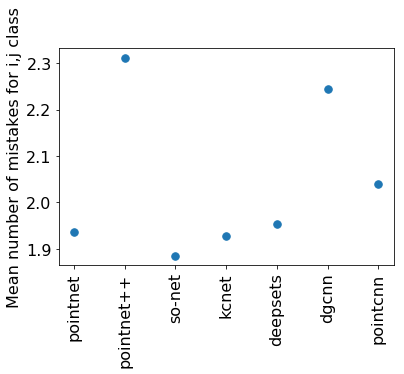

In [99]:
x = np.arange(len(BASE_MODELS))
y = [np.mean([mis for mis in mistakes[model] if mis != 0]) for model in BASE_MODELS]
e = [np.std([mis for mis in mistakes[model] if mis != 0]) for model in BASE_MODELS]
#e = [np.std(mistakes[model]) for model in BASE_MODELS]
#plt.errorbar(x, y, e, linestyle='None', marker='^')

plt.ylabel('Mean number of mistakes for i,j class')
plt.xticks(np.arange(len(BASE_MODELS)), BASE_MODELS, rotation=90)
plt.plot(x, y, linestyle='None', marker='.', markersize=15)
plt.savefig('mistakes.png', bbox_inches='tight')
plt.show()